# HW 2
Let's start with data upload

In [39]:
import pandas
from collections import Counter
import random
from IPython import display
import time
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from numpy.linalg import eig
from scipy.integrate import odeint

%matplotlib inline

In [ ]:
Articles = pandas.read_excel('articles.xls')
Articles = Articles.dropna()

In [41]:
authors = []
for i in range(len(Articles)):
    try:
        if Articles['date'][i].year == 2015:
            authors.append(Articles['Author'][i])
    except:
        pass

In [42]:
res={}
for i in authors:
    try:
        aus=i.split(';')
        auids=[l.split(':')[1] for l in aus]
        for j in auids:
            c=Counter([k for k in auids if k!=j])
            if j in res:
                res[j]+=c
            else:
                res[j]=c
    except IndexError:
        continue

In [43]:
edges=[]
for k, v in res.items():
    for j, w in v.items():
        edges.append((k, j, w))

In [44]:
G=nx.Graph()
G.add_weighted_edges_from(edges)

Now we got some weighted graph for 2015 year.

I suppose, it's good idea to choose big connected component

It turns out, that the biggest connected component got all weights equal to 1, so let's choose component which has more than 50 node and at the same time got biggest number of differently weighted edges

In [91]:
def check_weights(G):
    total = 0
    for (_, _, d) in G.edges(data=True):
        if d['weight'] != 1:
            #print(d['weight'])
            total += 1
    return total

In [87]:
Gc = max(nx.connected_component_subgraphs(G), key=lambda x: (check_weights(x) * (len(x)>50)))
T=nx.convert_node_labels_to_integers(Gc)
print('Graph size:', len(T))
print('Graph size:', len(T.edges()))

Graph size: 88
Graph size: 1252


In [88]:
check_weights(T)

11

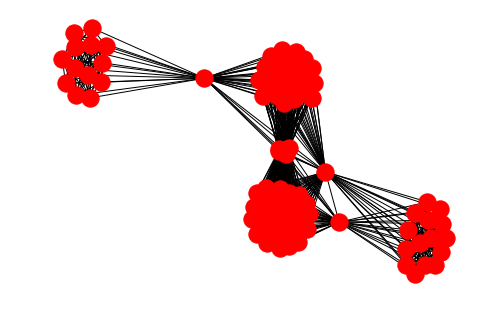

In [47]:
nx.draw(T)

Well, component with the biggest number of differently weighted edges got only 11 edges which are not weighted as '1' ... out of 1.2k edges

Let's delete some of this edges, using random walk sampling

In [133]:
class SRW():

    def __init__(self):
        self.growth_size = 2
        self.T = 100 
        self.fly_back_prob = 0.15

    def random_walk_sampling_with_fly_back(self,complete_graph, nodes_to_sample, fly_back_prob):
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n

        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample

        index_of_first_random_node = random.randint(0, nr_nodes-1)
        sampled_graph = nx.Graph()

        sampled_graph.add_node(complete_graph.node[index_of_first_random_node]['id'])

        iteration = 1
        edges_before_t_iter = 0
        curr_node = index_of_first_random_node
        while sampled_graph.number_of_nodes() != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            sampled_graph.add_node(chosen_node)
            sampled_graph.add_edge(curr_node, chosen_node, weight=complete_graph[curr_node][chosen_node]['weight'])
            choice = np.random.choice(['prev','neigh'], 1, p=[fly_back_prob,1-fly_back_prob])
            if choice == 'neigh':
                curr_node = chosen_node
            iteration=iteration+1

            if iteration % self.T == 0:
                if ((sampled_graph.number_of_edges() - edges_before_t_iter) < self.growth_size):
                    curr_node = random.randint(0, nr_nodes-1)
                    print("Choosing another random node to continue random walk ")
                    
                edges_before_t_iter = sampled_graph.number_of_edges()

        return sampled_graph

In [200]:
srw = SRW()

sampled_G = srw.random_walk_sampling_with_fly_back(T, 80, .6)
processed_G = nx.convert_node_labels_to_integers(sampled_G)
print('Not "1" weighted edges: ', check_weights(processed_G))
print('Total number of edges: ', len(processed_G.edges()))


Not "1" weighted edges:  3
Total number of edges:  385


## SIR simulation

Now let's create simulation process

In [341]:
class SIR_simulation():
    def __init__(self, G, p = .05, infected_num = 3):
        self.G = G
        self.pos=nx.spring_layout(self.G)
        self.p = p

        self.percolated_edges = [(u, v) for (u, v, d) in self.G.edges(data=True) if  np.random.rand() < d['weight'] * self.p]
        self.infected = set(np.random.choice(range(len(self.G)), infected_num))
        self.immune = set()
        self.treated = dict()
        self.money_spent = 0
        self.day = 0
        self.pre_vaccination()
        self.first_infected = len(self.infected)
        
    def step(self):
        self.day += 1
        self.check_treated()
        self.treatment_procedure()
        for from_nd in self.infected.copy():
            for to_nd in self.G[from_nd]:
                if (from_nd, to_nd) in self.percolated_edges or \
                   (to_nd, from_nd) in self.percolated_edges:
                    if to_nd not in self.immune:
                        self.infected.add(to_nd)
    
    def pre_vaccination(self):
        """"""
    
    def treatment_procedure(self):
        for from_nd in self.infected.copy():
            if from_nd not in self.treated:
                self.treat(from_nd)
                
    def check_treated(self):
        for node in self.treated.copy():
            self.treated[node] -= 1
            if self.treated[node] == 0:
                self.treated.pop(node)
                self.cure(node)
            
    def vaccinate(self, node):
        self.cure(node)
        self.money_spent += 500
    
    def treat(self, node):
        self.treated[node] = np.random.randint(3, 8)
        self.money_spent += 120
    
    def cure(self, node):
        self.immune.add(node)
        if node in self.infected:
            self.infected.remove(node)
    
    def is_cured(self):
        return not len(self.infected)
    
    def get_day(self):
        return self.day
    
    def get_money_spent(self):
        return self.money_spent
    
    def draw(self): 
        nx.draw_networkx_nodes(self.G,
                               self.pos,
                               node_color='k',
                               node_size=150,
                               alpha=1)  
            
        nx.draw_networkx_nodes(self.G,
                               self.pos,
                               nodelist=self.infected,
                               node_color='r',
                               node_size=150,
                               alpha=1)
        
        nx.draw_networkx_nodes(self.G,
                               self.pos,
                               nodelist=self.immune,
                               node_color='g',
                               node_size=150,
                               alpha=1)
        nx.draw_networkx_nodes(self.G,
                               self.pos,
                               nodelist=self.treated,
                               node_color='#7CFC00',
                               node_size=150,
                               alpha=1)
        
        nx.draw_networkx_edges(self.G,self.pos,width=1.5,alpha=0.5)
        
        nx.draw_networkx_edges(self.G,self.pos,
                       edgelist=self.percolated_edges,
                       width=1.5,alpha=0.5,edge_color='b')
        plt.axis('off')

        plt.rcParams['figure.figsize'] = [20, 20]
        #plt.show()
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
    def get_inf(self):
        print(self.first_infected)

Above this cell lays template for simulation process.

The default treatment procedure is very simple: we don't vaccinate anyone, just treat anyone, who gets ill

In order to change treatment procedure, we gotta change "pre_vaccination" and "treatment_procedure"

Simulation functions are implemented below:

Silent, to get average results and with step-by-step visualisation

In [249]:
def silent_simulate(G, simulation, p, infected_num):
    Model = simulation(G, p=p, infected_num=infected_num)
    while not Model.is_cured():
        Model.step()
    return (Model.get_day(), Model.get_money_spent())

In [250]:
def get_average(G, simulation, p, infected_num, n=100):
    total_money = 0
    total_days = 0
    for (days, money) in [silent_simulate(G, simulation, p, infected_num) for _ in range(n)]:
        total_days += days
        total_money += money
    print("Average days: ", total_days/n)
    print("Average money: ", total_money/n)

In [360]:
def simulate(G, simulation, p, infected_num):
    Model = simulation(G, p=p, infected_num=infected_num)
    Model.draw()
    #Model.get_inf()
    time.sleep(1)
    while not Model.is_cured():
        Model.step()
        Model.draw()
        #time.sleep(1)
    print('Total number of days to cure', Model.get_day())
    print('Total money spent', Model.get_money_spent())

Now, when we are all prepared, we can start evaluating our treatment methods

First, let's try our default method with number of infected nodes equal to 8

Total number of days to cure 8
Total money spent 1440


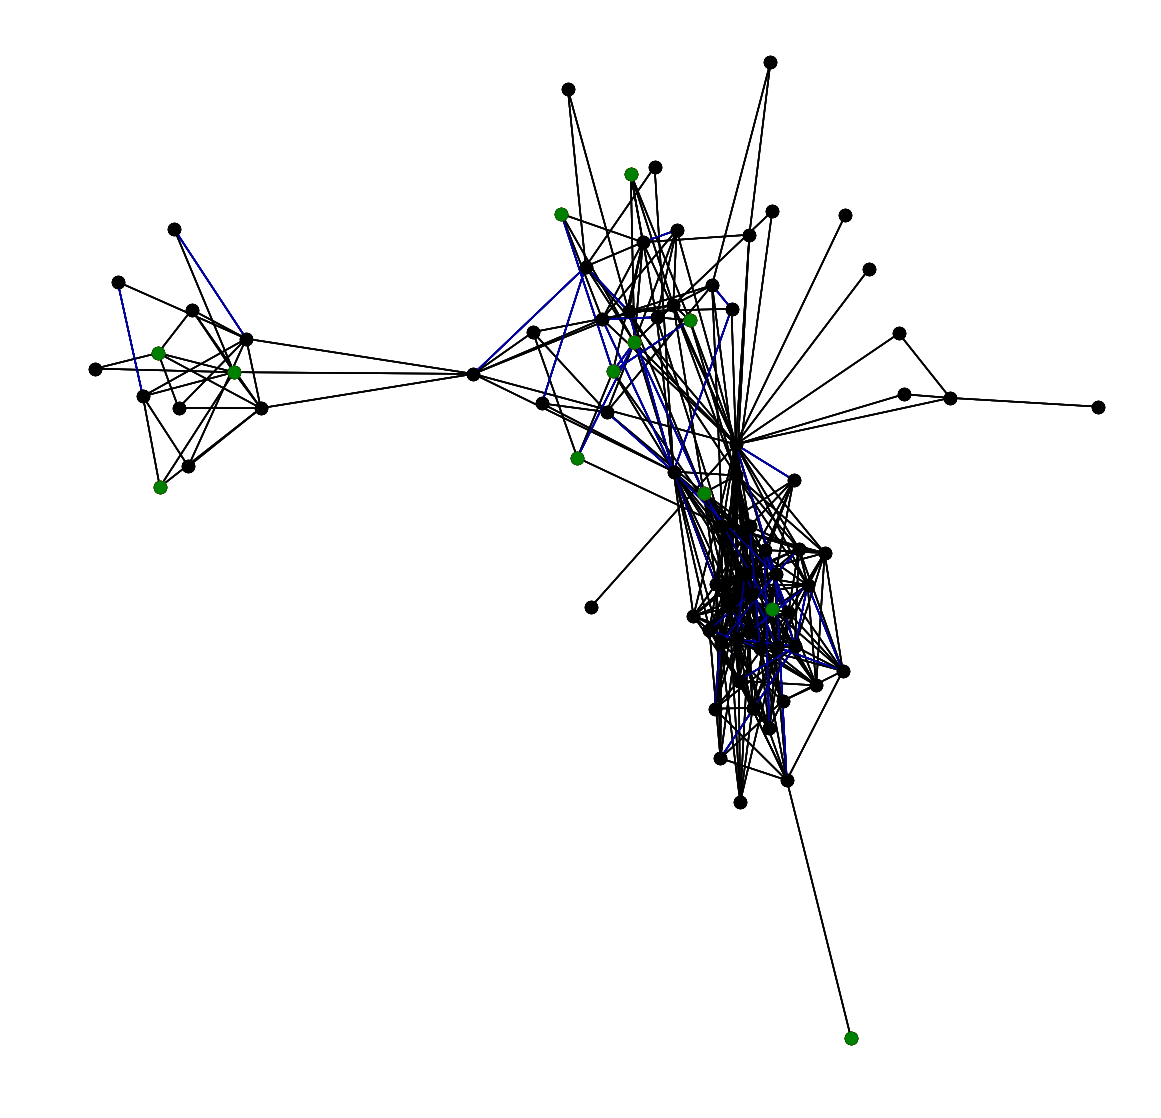

In [287]:
simulate(processed_G, simulation=SIR_simulation, p=.1, infected_num=8)

Now let's calculate average values over 100 simulations

In [288]:
get_average(processed_G, simulation=SIR_simulation, p=.1, infected_num=20)

Average days:  11.34
Average money:  5326.8


For now we can't say, how well our methods perform

Let's implement several new methods

For this one, we will treat 10% of all nodes with vaccination and after that, each day we will treat everyone who gets ill

In [346]:
class random_treatment(SIR_simulation):
    def pre_vaccination(self):
        vacc = list(self.infected)[0: int(len(self.G)/10)]
        for nd in vacc:
            self.vaccinate(nd)

0
Total number of days to cure 0
Total money spent 4000


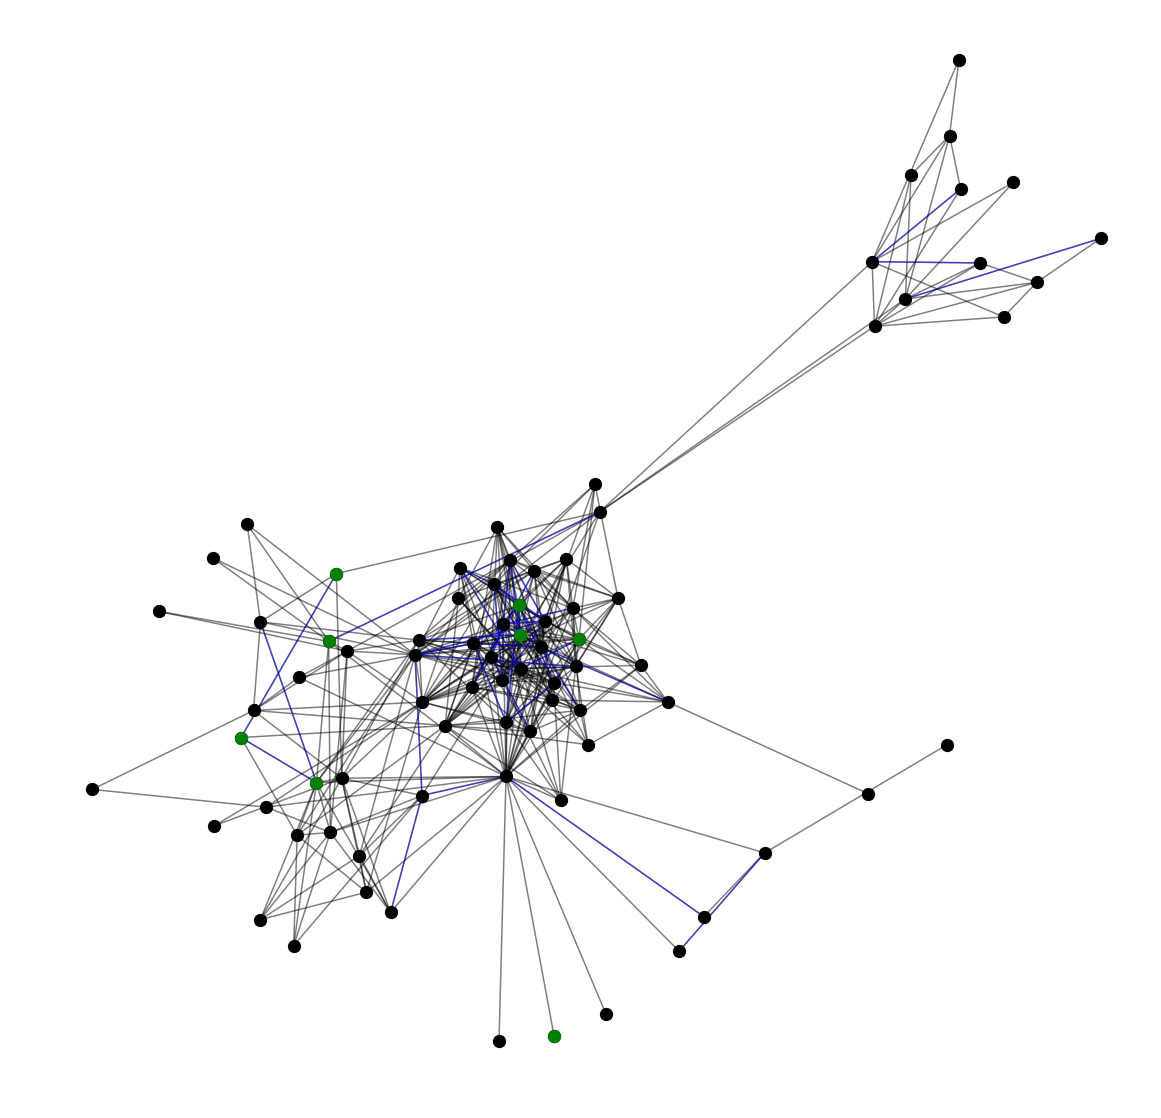

In [347]:
simulate(processed_G, simulation=first_treatment, p=.1, infected_num=8)

In [292]:
get_average(processed_G, simulation=first_treatment, p=.1, infected_num=8)

Average days:  0.0
Average money:  3835.0


For infected number 8, we treat all the infected nodes on the first day, not giving any chance for illness to spread.

If we change this number for 10, our values are still better than on the first simulation

In [296]:
get_average(processed_G, simulation=SIR_simulation, p=.1, infected_num=10)

Average days:  12.51
Average money:  4255.2


In [298]:
get_average(processed_G, simulation=first_treatment, p=.1, infected_num=10)

Average days:  9.23
Average money:  5419.6


But if we change infected number a bit more, our results get very close to each other (in terms of days for treatment, while money differ for quite a bit)

In [322]:
get_average(processed_G, simulation=SIR_simulation, p=.1, infected_num=15)

Average days:  12.1
Average money:  4812.0


In [319]:
get_average(processed_G, simulation=first_treatment, p=.1, infected_num=15)

Average days:  12.08
Average money:  7140.4


Let's implement a bit more complicated treatment strategy.

For this time, we will use Closeness Centrality for the first treatment

In [325]:
class closeness_treatment(SIR_simulation):
    def pre_vaccination(self):
        vacc_num = int(len(self.G)/10)
        Close_centr = sorted([(k, v) for k, v in nx.closeness_centrality(processed_G).items()],
                             key = lambda x: x[1],
                             reverse=True)
        vacc = [nd for (nd, _) in Close_centr if nd in self.infected][0: vacc_num]
        for nd in vacc:
            self.vaccinate(nd)

In [335]:
get_average(processed_G, simulation=closeness_treatment, p=.1, infected_num=15)

Average days:  10.2
Average money:  5719.6


Well, now we are talking

It turns out, that it's the best method we've implemented so far (again, in terms of total days)

For the next simulations, lets try other centralities

In [330]:
class degree_treatment(SIR_simulation):
    def pre_vaccination(self):
        vacc_num = int(len(self.G)/10)
        Close_centr = sorted([(k, v) for k, v in nx.degree_centrality(processed_G).items()],
                             key = lambda x: x[1],
                             reverse=True)
        vacc = [nd for (nd, _) in Close_centr if nd in self.infected][0: vacc_num]
        for nd in vacc:
            self.vaccinate(nd)

In [333]:
get_average(processed_G, simulation=degree_treatment, p=.1, infected_num=15)

Average days:  9.86
Average money:  5512.0


In [336]:
class betweenness_treatment(SIR_simulation):
    def pre_vaccination(self):
        vacc_num = int(len(self.G)/10)
        Close_centr = sorted([(k, v) for k, v in nx.betweenness_centrality(processed_G).items()],
                             key = lambda x: x[1],
                             reverse=True)
        vacc = [nd for (nd, _) in Close_centr if nd in self.infected][0: vacc_num]
        for nd in vacc:
            self.vaccinate(nd)

In [338]:
get_average(processed_G, simulation=betweenness_treatment, p=.1, infected_num=15)

Average days:  10.85
Average money:  5996.8


All the centrality based methods above got similar results

Finally, let's compare default, random and centralities methods using different params

In [356]:
n = 6
infected_array = [5 * i for i in range(1, n)]
p = [.1 for i in range(n)]
sims = {
    'Default': SIR_simulation,
    'Random': random_treatment,
    'Closeness': closeness_treatment,
    'Degree': degree_treatment,
    'Betweenness': betweenness_treatment,
}

for i in range(n-1):
    for name, method in sims.items():
        print(name + ' Simulation, infected_num = ', infected_array[i])
        get_average(processed_G, simulation=method, p=.1, infected_num=infected_array[i], n=200)
        print()
    print('_'*10 + '\n')

Default Simulation, infected_num =  5
Average days:  12.645
Average money:  3250.2

Random Simulation, infected_num =  5
Average days:  0.0
Average money:  2457.5

Closeness Simulation, infected_num =  5
Average days:  0.0
Average money:  2447.5

Degree Simulation, infected_num =  5
Average days:  0.0
Average money:  2432.5

Betweenness Simulation, infected_num =  5
Average days:  0.0
Average money:  2460.0

__________

Default Simulation, infected_num =  10
Average days:  12.52
Average money:  4263.6

Random Simulation, infected_num =  10
Average days:  10.725
Average money:  5700.2

Closeness Simulation, infected_num =  10
Average days:  6.85
Average money:  4458.1

Degree Simulation, infected_num =  10
Average days:  6.74
Average money:  4359.2

Betweenness Simulation, infected_num =  10
Average days:  6.88
Average money:  4439.7

__________

Default Simulation, infected_num =  15
Average days:  11.82
Average money:  4729.8

Random Simulation, infected_num =  15
Average days:  12.03

Here we can see, that when number of infected nodes grow our methods become more and more similar to each other. It's because with growth of infected_num, growth the number of remaining nodes after first vaccination.

In [358]:

infected_array = [5 * i for i in range(1, n)]
ps = [.1, .3, .5, .7]
sims = {
    'Default': SIR_simulation,
    'Random': random_treatment,
    'Closeness': closeness_treatment,
    'Degree': degree_treatment,
    'Betweenness': betweenness_treatment,
}

for p in ps:
    for name, method in sims.items():
        print(name + ' Simulation, p =', p)
        get_average(processed_G, simulation=method, p=p, infected_num=13, n=200)
        print()
    print('_'*10 + '\n')

Default Simulation, p = 0.1
Average days:  12.115
Average money:  4478.4

Random Simulation, p = 0.1
Average days:  12.09
Average money:  6691.0

Closeness Simulation, p = 0.1
Average days:  9.9
Average money:  5387.2

Degree Simulation, p = 0.1
Average days:  9.365
Average money:  5131.6

Betweenness Simulation, p = 0.1
Average days:  9.945
Average money:  5330.8

__________

Default Simulation, p = 0.3
Average days:  11.375
Average money:  7885.2

Random Simulation, p = 0.3
Average days:  12.355
Average money:  10321.0

Closeness Simulation, p = 0.3
Average days:  12.67
Average money:  9333.4

Degree Simulation, p = 0.3
Average days:  12.4
Average money:  9254.8

Betweenness Simulation, p = 0.3
Average days:  12.64
Average money:  9350.8

__________

Default Simulation, p = 0.5
Average days:  10.925
Average money:  8892.0

Random Simulation, p = 0.5
Average days:  12.405
Average money:  11432.8

Closeness Simulation, p = 0.5
Average days:  12.59
Average money:  11227.6

Degree Simula

Well, these results seem interesting. With increasing of 'p', number of days for treatment alsa increases. At the same time, default implemetations performs better. That might be because, vaccinationg several nodes first, we cut out pathes to some nodes, while with bigger 'p', illness still will reach these distinct node, it will need mode time for that

Total number of days to cure 12
Total money spent 12640


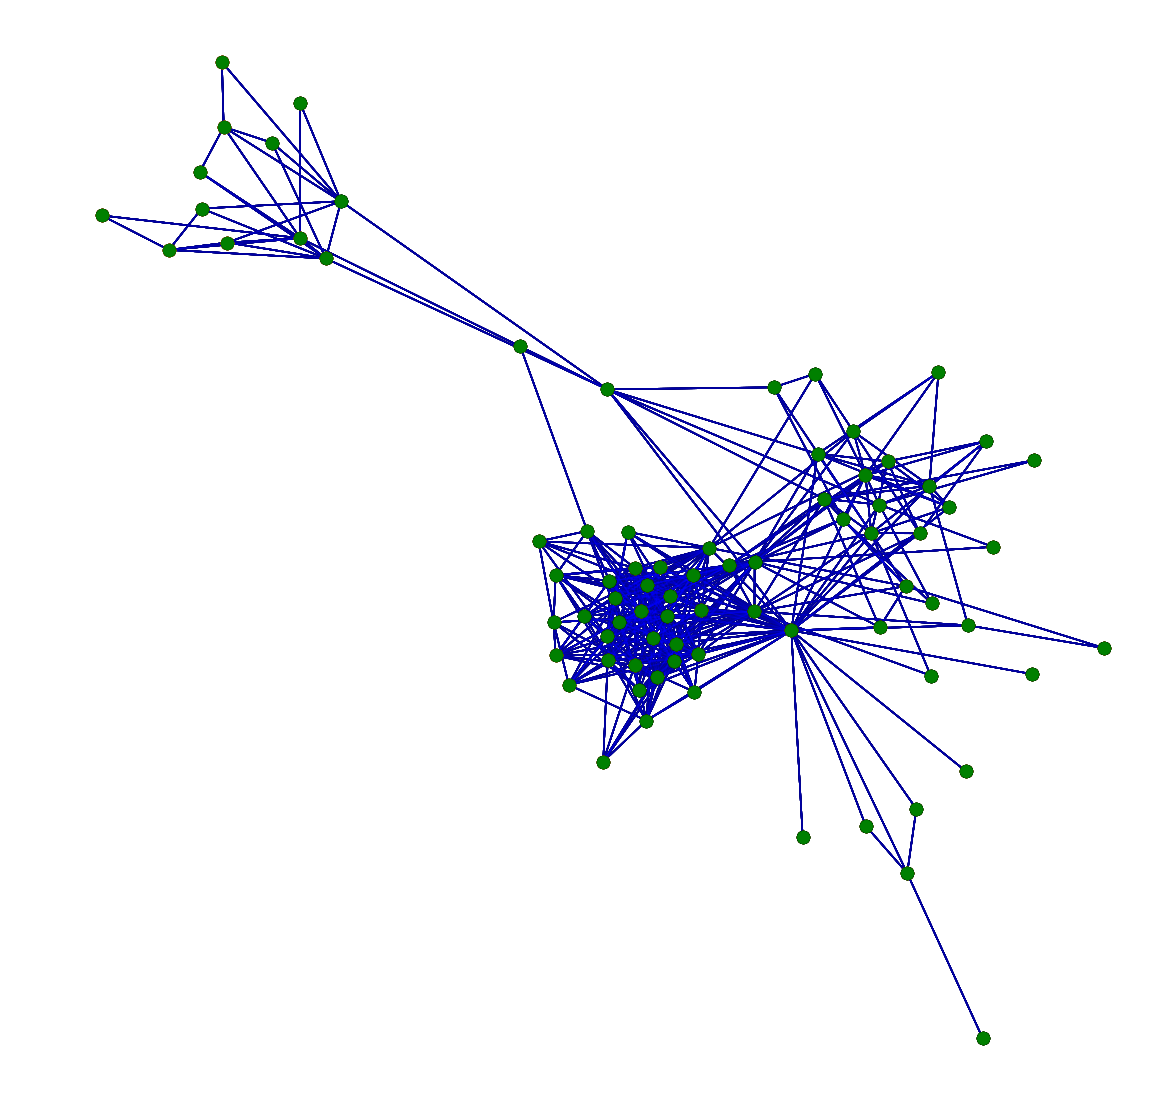

In [361]:
simulate(processed_G, simulation=degree_treatment, p=1, infected_num=15)

Total number of days to cure 8
Total money spent 4720


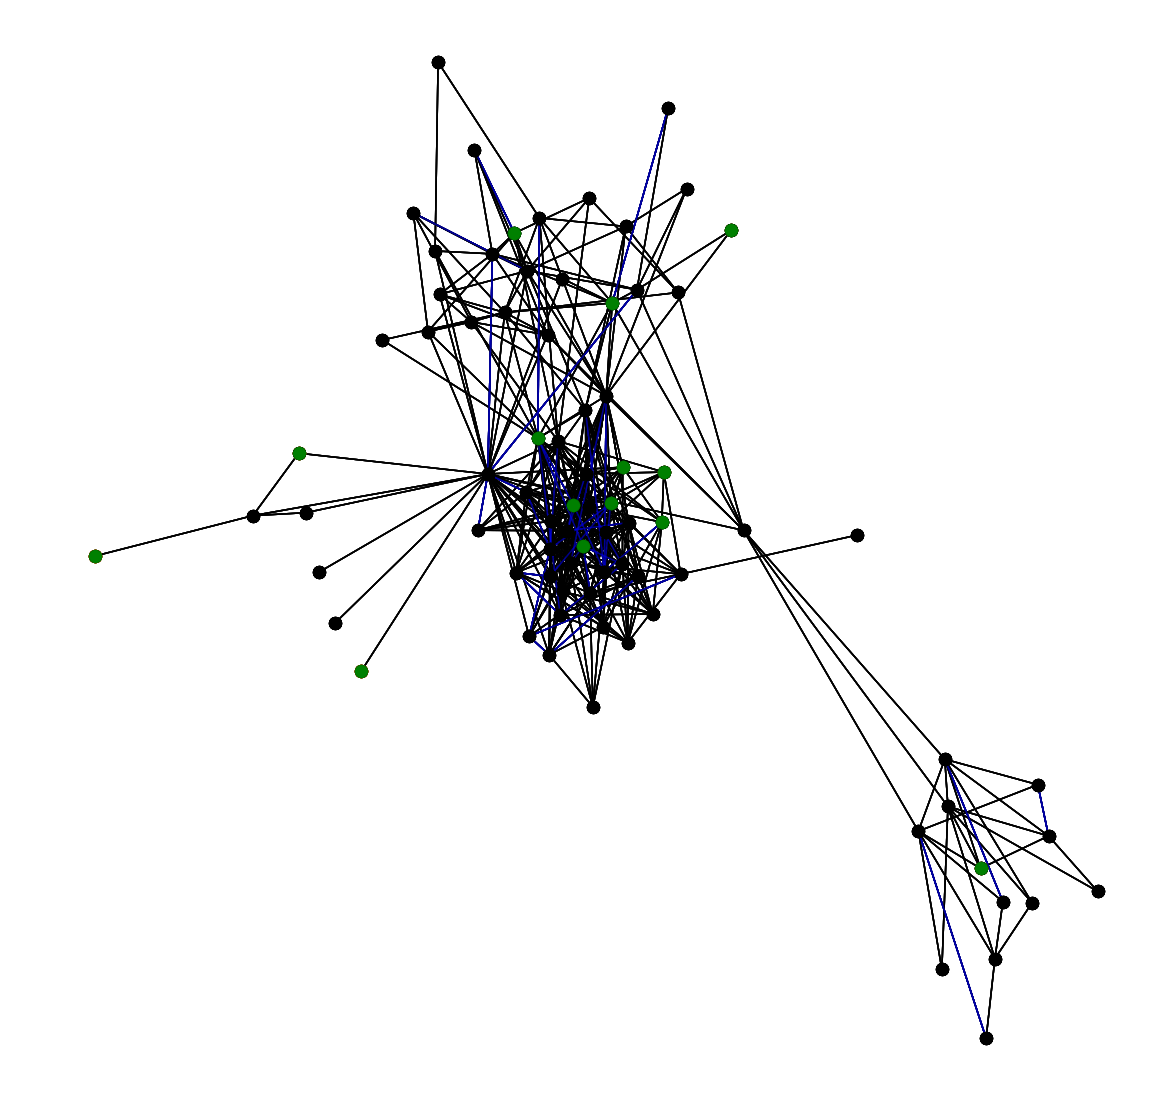

In [362]:
simulate(processed_G, simulation=degree_treatment, p=.1, infected_num=15)

Yep, as excpected, illness just needs some time to reach distinct nodes, while lower 'p' just cuts off those nodes